In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import missingno as msno
import nltk
import string
from nltk.tokenize import word_tokenize
import spacy
from collections import Counter
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
spacy.load('en')
puncts = string.punctuation
from spacy.lang.en.stop_words import STOP_WORDS
nlp = English()

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
#Location Nulls
7613-5080

2533

In [6]:
#Keyword Nulls
7613-7552

61

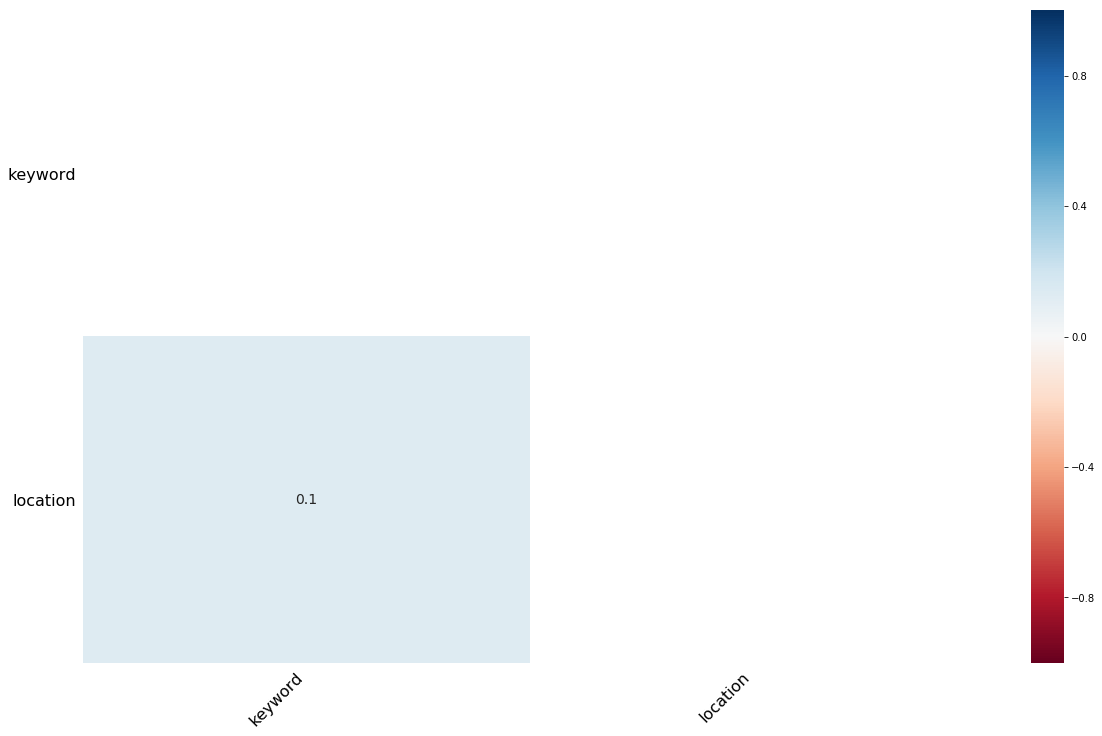

In [7]:
msno.heatmap(data)

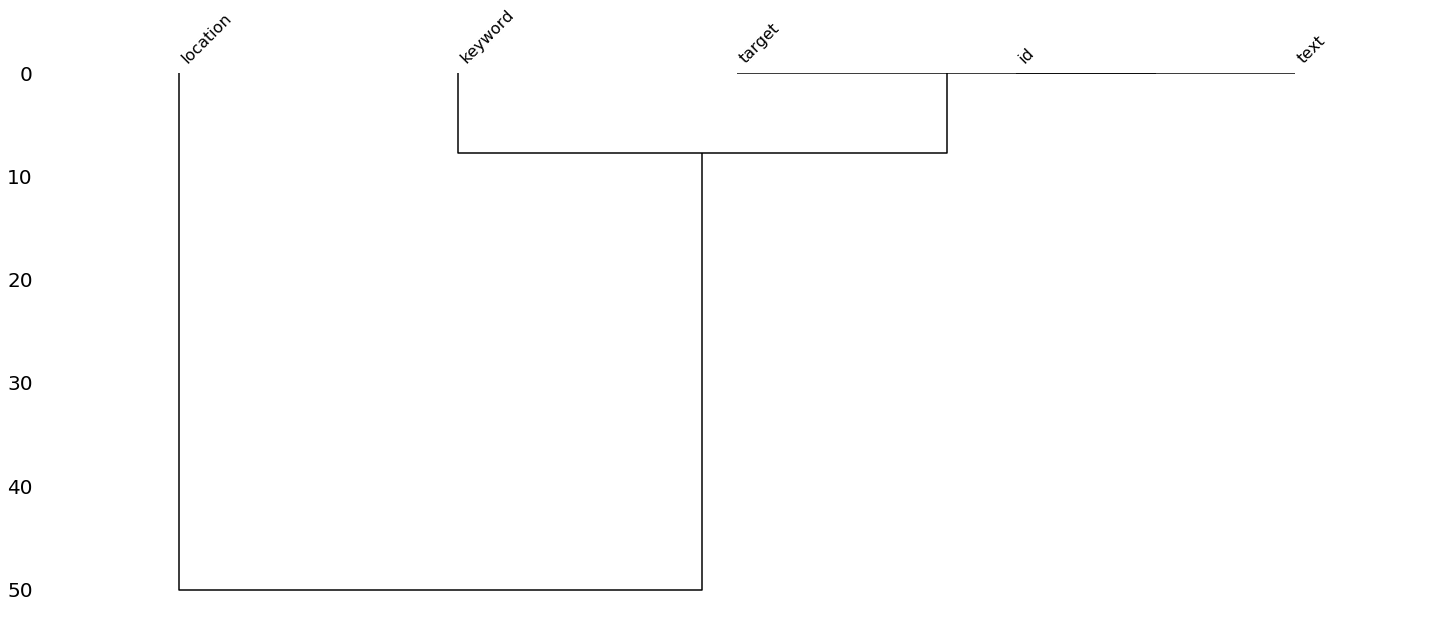

In [8]:
msno.dendrogram(data)

In [9]:
data.fillna(value=' ',axis=1,inplace=True)

In [10]:
data.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7613 non-null object
location    7613 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
data['combined'] = data.keyword + ' ' + data.location + ' ' + data.text
data.head()

,id,keyword,location,text,target,combined
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthqua...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' ...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuatio..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska...


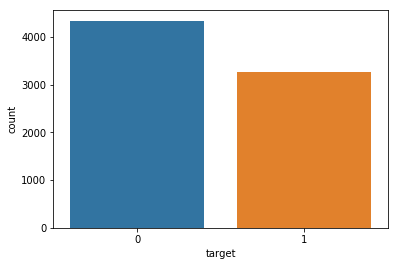

In [13]:
ax =sns.countplot(x='target',data=data)

In [14]:
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

In [15]:
def clean_text(docs):
    texts = []
    for doc in docs:
        doc = ' '.join(unique_list(doc.split()))
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [token.lemma_.lower().strip() for token in doc if token.lemma_ != '-PRON-']
        tokens = [token for token in tokens if token not in STOP_WORDS]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [16]:
combined_text = [text for text in data.combined.str.strip()]
combined_text_clean = clean_text(combined_text)
data['combined_clean'] = combined_text_clean

In [17]:
def text_preprocess(tweet):
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#|@|\.|amp', '', tweet)
    tweet = re.sub(r'['+puncts+']+', ' ', tweet)
    tweet = re.sub(r'\d+','',tweet)
    return str(tweet).strip()
data.combined_clean = data.combined_clean.apply(text_preprocess)

In [18]:
disaster_text= [text for text in data[data.target == 1].combined_clean.str.strip()]
disaster_text = ' '.join(disaster_text).split()
non_disaster_text= [text for text in data[data.target == 0].combined_clean.str.strip()]
non_disaster_text = ' '.join(non_disaster_text).split()
disaster_text_count = Counter(disaster_text)
non_disaster_text_count = Counter(non_disaster_text)

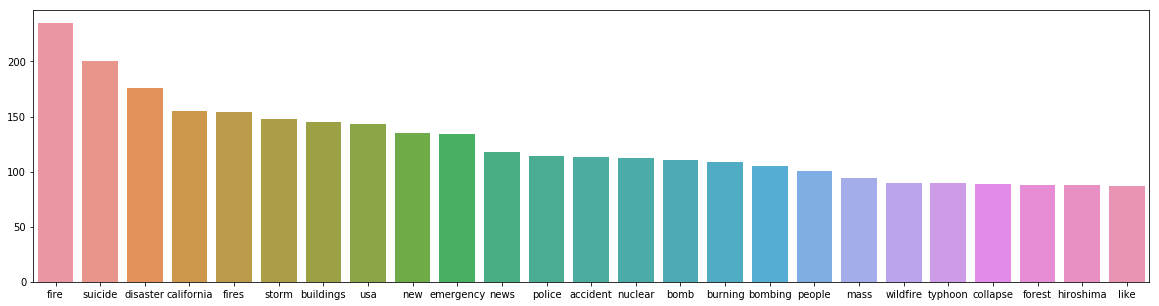

In [19]:
disaster_common_words = [word[0] for word in disaster_text_count.most_common(25)]
disaster_common_counts = [word[1] for word in disaster_text_count.most_common(25)]
figure = plt.figure(figsize = (20,5))
ax = sns.barplot(x=disaster_common_words,y=disaster_common_counts)

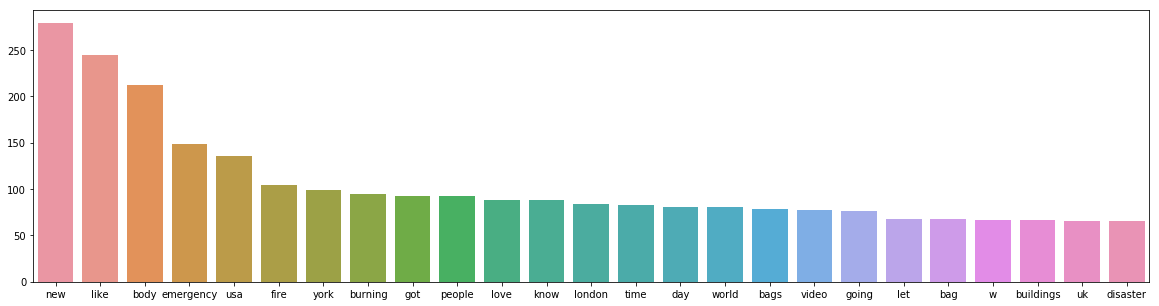

In [20]:
non_disaster_common_words = [word[0] for word in non_disaster_text_count.most_common(25)]
non_disaster_common_counts = [word[1] for word in non_disaster_text_count.most_common(25)]
figure = plt.figure(figsize = (20,5))
ax = sns.barplot(x=non_disaster_common_words,y=non_disaster_common_counts)

In [21]:
tfidf_vector = TfidfVectorizer()
text_tfidf = tfidf_vector.fit_transform(data.combined_clean)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, data.target, test_size=0.3, random_state=42)

In [23]:
log_clf = LogisticRegression(random_state=42).fit(X_train, y_train)
predictions = log_clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1318
           1       0.82      0.65      0.73       966

    accuracy                           0.79      2284
   macro avg       0.80      0.77      0.78      2284
weighted avg       0.80      0.79      0.79      2284



/Users/akarshb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1318
           1       0.67      0.67      0.67       966

    accuracy                           0.72      2284
   macro avg       0.71      0.71      0.71      2284
weighted avg       0.72      0.72      0.72      2284



In [25]:
clf = RandomForestClassifier(random_state=42,n_estimators=10)
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81      1318
           1       0.80      0.58      0.67       966

    accuracy                           0.76      2284
   macro avg       0.77      0.74      0.74      2284
weighted avg       0.77      0.76      0.75      2284



In [26]:
test_data = pd.read_csv('test.csv')

In [27]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [28]:
test_data.fillna(value=' ',axis=1,inplace=True)
test_data['combined'] = test_data.keyword + ' ' + test_data.location + ' ' + test_data.text
combined_text = [text for text in test_data.combined.str.strip()]
combined_text_clean = clean_text(combined_text)
test_data['combined_clean'] = combined_text_clean
test_data.combined_clean = test_data.combined_clean.apply(text_preprocess)

In [29]:
test_data.head()

,id,keyword,location,text,combined,combined_clean
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash,happened terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...",Heard about #earthquake is different citie...,heard earthquake different cities stay safe
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese...",forest fire spot pond geese fleeing street ...
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


In [30]:
test_text_tfidf = tfidf_vector.transform(test_data.combined_clean)

In [31]:
log_predictions = log_clf.predict(test_text_tfidf)
log_predictions

array([1, 1, 1, ..., 1, 1, 0])

In [32]:
test_data.shape

(3263, 6)

In [33]:
submission = pd.DataFrame(columns=['id','target'])

In [34]:
submission['id'] = test_data.id
submission['target'] = log_predictions

In [35]:
submission.shape

(3263, 2)

In [39]:
submission.to_csv('sumbmission.csv',sep=',',index=False)